In [1]:
%load_ext autoreload
%autoreload 2.0
%matplotlib inline

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import glob
# import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import numpy as np
# import tensorflow as tf
import sys
sys.path.insert(0, '../.')
from data.segmentation_dataset_loader import *
from data.detection_dataset_loader import *
from model import *
# from Trainer import *
from evaluation.evaluate import *
from data.postprocessing.nms import *
from scipy.spatial.transform import Rotation as R

/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/apple/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
training=True
base_path = '/Users/apple/Desktop/Master/Data/'
list_files = list(map(lambda x: x.split('.')[0], os.listdir(base_path+'/data_object_image_3/training/image_3')))
random.seed(0)
random.shuffle(list_files)

camera_paths = list(map(lambda x: base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
lidar_paths = list(map(lambda x: base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
label_paths = list(map(lambda x: base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
calib_paths = list(map(lambda x: base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
        
ln = int(len(list_files) * 0.5)
final_sample = len(list_files)

# ln = int(10 * 0.5)
# final_sample = 10
        
if training:
            list_files = list_files[:ln]
            list_camera_paths = camera_paths[:ln]
            list_lidar_paths = lidar_paths[:ln]
            list_label_paths = label_paths[:ln]
            list_calib_paths = calib_paths[:ln]
else:
            list_camera_paths = camera_paths[ln:final_sample]
            list_lidar_paths = lidar_paths[ln:final_sample]
            list_label_paths = label_paths[ln:final_sample]
            list_calib_paths = calib_paths[ln:final_sample]
            list_files = list_files[ln:final_sample]


In [4]:
i_c = 3
current_file = list_files[i_c]
current_file

'000007'

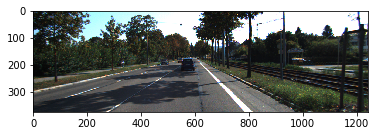

In [5]:
img = mpimg.imread(base_path + '/data_object_image_3/training/image_3/' +current_file+".png")
plt.imshow(img)

In [6]:
t = base_path + '/data_object_label_2/training/label_2/' +current_file+".txt"
!cat $t

Car 0.00 0 -1.56 564.62 174.59 616.43 224.74 1.61 1.66 3.20 -0.69 1.69 25.01 -1.59
Car 0.00 0 1.71 481.59 180.09 512.55 202.42 1.40 1.51 3.70 -7.43 1.88 47.55 1.55
Car 0.00 0 1.64 542.05 175.55 565.27 193.79 1.46 1.66 4.05 -4.71 1.71 60.52 1.56
Cyclist 0.00 0 1.89 330.60 176.09 355.61 213.60 1.72 0.50 1.95 -12.63 1.88 34.09 1.54
DontCare -1 -1 -10 753.33 164.32 798.00 186.74 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 738.50 171.32 753.27 184.42 -1 -1 -1 -1000 -1000 -1000 -10


In [17]:
r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
rot = r.as_dcm()
rot = np.append(rot, np.array([[0,0,0]]), axis=0)
rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

tr_x = 2
tr_y = 0
tr_z = 0
tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

sc_x = 1
sc_y = 1
sc_z = 1
sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

In [18]:

# current_file = list_files2[3]
    
translate_x = 0
translate_y = 0
translate_z = 0
ang = 0
fliplr = False

# i_c = 25
# current_file = list_files2[i_c]
# current_file

h, w, _ = cv2.imread(base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png').shape
all_data, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=False,
                                                         ang=ang, translate_x=translate_x,
                                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

tr_x = 0
tr_y = 0
tr_z *=-1
tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
lidar_image = velo_points_bev(rot, tr, sc, base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin',
                              base_path + '/data_object_calib/training/calib/'+ current_file + '.txt',
                           size=(512, 448, 40), img_height=375, img_width=1242, ang=ang, translate_x=translate_x,
                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

# label = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

[[-0.69  1.69 25.01]
 [-7.43  1.88 47.55]
 [-4.71  1.71 60.52]]
[[27.29903674  0.70895803 -1.49342353]
 [49.83821028  7.45339215 -1.37663235]
 [62.80636499  4.73336101 -1.09983036]]


In [9]:

# current_file = list_files2[3]
    
translate_x = 0
translate_y = 0
translate_z = 0
ang = 0
fliplr = False

# i_c = 25
# current_file = list_files2[i_c]
# current_file

h, w, _ = cv2.imread(base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png').shape
all_data, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt', 
                                                  base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
                                                  0, 0, get_actual_dims=False,
                                                         ang=ang, translate_x=translate_x,
                                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

tr_x = 0
tr_y = 0
tr_z *=-1
tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
lidar_image = velo_points_bev(rot, tr, sc, base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin',
                              base_path + '/data_object_calib/training/calib/'+ current_file + '.txt',
                           size=(512, 448, 40), img_height=375, img_width=1242, ang=ang, translate_x=translate_x,
                              translate_y=translate_y, translate_z=translate_z, fliplr=fliplr)

label = get_target(label, directions,  anchors=np.array([3.9, 1.6, 1.5]))

[[-0.69  1.69 25.01]
 [-7.43  1.88 47.55]
 [-4.71  1.71 60.52]]
[[25.29903674  0.70895803 -1.49342353]
 [47.83821028  7.45339215 -1.37663235]
 [60.80636499  4.73336101 -1.09983036]]


In [ ]:
Car 0.00 0 -1.56 564.62 174.59 616.43 224.74 1.61 1.66 3.20 -0.69 1.69 25.01 -1.59
Car 0.00 0 1.71 481.59 180.09 512.55 202.42 1.40 1.51 3.70 -7.43 1.88 47.55 1.55
Car 0.00 0 1.64 542.05 175.55 565.27 193.79 1.46 1.66 4.05 -4.71 1.71 60.52 1.56

In [19]:
label

array([[329.91820033, 220.53869701,  25.31087938,   3.2       ,
          1.66      ,   1.61      ,   1.55      ],
       [167.69964152, 182.85417137,  24.17216537,   3.7       ,
          1.51      ,   1.4       ,   1.55      ],
       [ 74.36545761, 198.05234537,  21.47334604,   4.05      ,
          1.66      ,   1.46      ,   1.56      ]])

In [33]:
label

array([[322.72101723, 216.57739401,  25.31087938,   3.2       ,
          1.66      ,   1.61      ,   1.55      ],
       [160.50245843, 141.20834274,  24.17216537,   3.7       ,
          1.51      ,   1.4       ,   1.55      ],
       [ 67.16827451, 171.60469074,  21.47334604,   4.05      ,
          1.66      ,   1.46      ,   1.56      ]])

In [9]:
label = get_target(label, directions,  anchors= np.array([3.9, 1.6, 1.5]))

In [10]:
# label

(512, 448)
322.72101723223966 216.5773940126039 23.03574841314047 18.54745286895262 -88.80849
160.5024584259429 141.20834273857082 26.636282858663062 16.871163005015966 -88.80849
67.16827451126397 171.60469073917056 29.149419003062768 18.548825913526787 -89.381448



<Figure size 432x288 with 0 Axes>

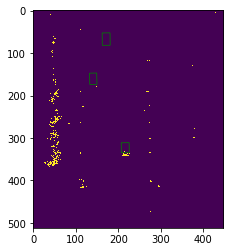

In [24]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[:, :, 20:40], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


<Figure size 432x288 with 0 Axes>

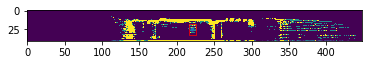

In [10]:
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image.transpose()[:, :, :], 2), 0, 1)
# img = cv2.resize(img, (112, 128))
ax.imshow(img)

for i in range(0, len(label)):
    l = label[i][3]
    w = label[i][4] 
    h = label[i][5]
    x = label[i][0]
    y = label[i][1]
    z = label[i][2]

    plt.scatter(y, z, s=10)
    a = label[i][6]
    if a < 0:
      a = a + 3.14
#     print(h, w, l)
#     print(y, z, x)
#     print()
    rect = patches.Rectangle((y-w/2, z-h/2),w, h, angle= 0,linewidth=0.75,edgecolor='r',facecolor='none')

    ax.add_patch(rect)
    break


plt.show()


In [10]:
def read_label2(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                    size=(512, 448, 40), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0, get_neg=False):
#     return __read_label(label_path, calib_path, shift_h, shift_w, x_range=x_range, y_range=y_range, z_range=z_range, 
#                     size=size, get_actual_dims=get_actual_dims, from_file=from_file, translate_x=translate_x, translate_y=translate_y, ang=ang, get_neg=get_neg)



# def __read_label(label_path, calib_path, shift_h, shift_w, x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
#                     size=(512, 448, 32), get_actual_dims=False, from_file=True, translate_x=0, translate_y=0, ang=0,
#                     get_neg=False):
    """
    the file format is as follows: 
    type, truncated, occluded, alpha, bbox_left, bbox_top, bbox_right, bbox_bottom,
    dimensions_height, dimensions_width, dimensions_length, location_x, location_y, location_z,
    rotation_y, score) 
    """
    if from_file:
        lines = []
        with open(label_path) as label_file:
            lines = label_file.readlines()
    else:
        lines = label_path.split('\n')
    # filter car class
    lines = list(map(lambda x: x.split(), lines))
    print('lines', len(lines))
    if len(lines) > 0:
        if get_neg:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] not in ['Car', 'Van', 'Truck', 'Tram', 'DontCare']), lines))
            if len(lines) > 0:
                lines = lines[:1]
        else:
            lines = list(filter(lambda x: len(x) > 0 and ( x[0] in ['Car']), lines))
#             print(len(lines))
    
    def get_parameter(index):
        return list(map(lambda x: x[index], lines))
    
    classes = get_parameter(0)
    dimension_height = np.array(get_parameter(8)).astype(float)
    dimension_width = np.array(get_parameter(9)).astype(float)
    dimension_length = np.array(get_parameter(10)).astype(float)
    # TODO: take shift into consideration - URGENT
    location_x = np.array(get_parameter(11)).astype(float)
    location_y = np.array(get_parameter(12)).astype(float)
    location_z = np.array(get_parameter(13)).astype(float)
    angles = np.array(get_parameter(14)).astype(float)
    
    # print(len(classes))
    calib_data = read_calib(calib_path)

    locations = np.array([[location_x[i], location_y[i], location_z[i]] for i in range(len(classes))])
#     print('locations', len(locations))
    if len(locations) > 0 and len(locations[0]) > 0:
        locations = project_rect_to_velo(locations, calib_data['R0_rect'].reshape((3, 3)), calib_data['Tr_velo_to_cam'].reshape((3, 4)))
#     print('locations', len(locations))
    # print(z_range)
    indxes = np.array(list(map(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))
#     print("indxes", len(indxes[indxes==True]))
#     print("indxes", indxes)
#     print(locations)
    locations = np.array(list(filter(lambda point: (point[0] >= x_range[0]  and point[0] <= x_range[1])
                                    and (point[1] >= y_range[0] and point[1] <= y_range[1])
                                    and (point[2] >= z_range[0] and point[2] <= z_range[1]) , locations)))

#     print(locations)
#     print('locations', len(locations))
    if len(locations) > 0:
        locations[:, :2] = locations[:, :2] - np.array([translate_x, translate_y])

    # print('.......')
    

    points = [project_point_from_camera_coor_to_velo_coor([location_x[i], location_y[i], location_z[i]], 
                                                        [dimension_height[i], dimension_width[i], dimension_length[i]],
                                                        angles[i],
                                                         calib_data)
                for i in range(len(locations))]
    
    x_size = (x_range[1] - x_range[0])
    y_size = (y_range[1] - y_range[0])
    z_size = (z_range[1] - z_range[0])
            
    x_fac = (size[0]-1) / x_size
    y_fac = (size[1]-1) / y_size
    z_fac = (size[2]-1) / z_size
    if get_actual_dims:
        import math
        for i in range(len(points)):
            b = points[i]
            x0 = b[0][0]
            y0 = b[0][1]
            x1 = b[1][0]
            y1 = b[1][1]
            x2 = b[2][0]
            y2 = b[2][1]
            u0 = -(x0) * x_fac + size[0]
            v0 = -(y0 + 40) * y_fac + size[1]
            u1 = -(x1) * x_fac + size[0]
            v1 = -(y1 + 40) * y_fac + size[1]
            u2 = -(x2) * x_fac + size[0]
            v2 = -(y2 + 40) * y_fac + size[1]
            # print(dimension_length[i])
            dimension_length[i] = math.sqrt((v1-v2)**2 + (u1-u2)**2)
            # print(dimension_length[i])
            dimension_width[i] = math.sqrt((v1-v0)**2 + (u1-u0)**2)
            # print(dimension_height[i])
            dimension_height[i] = math.sqrt((-(b[0][2]+(-1*z_range[1]))*z_fac-(-b[4][2]+z_range[1])*z_fac)**2)
            # print(dimension_height[i])

      


    x_range = (x_range[0] + translate_x, x_range[1] + translate_x)
    y_range = (y_range[0] + translate_y, y_range[1] + translate_y)
    output = [[-(locations[i][0]) * x_fac + size[0], -(locations[i][1] + -1*y_range[0]) * y_fac + size[1], -(locations[i][2] + -1*z_range[0]) * z_fac + size[2], 
                dimension_length[i], dimension_width[i], dimension_height[i], angles[i]] 
                for i in range(len(locations))]
    # import math
    if ang != 0:
        for i in range(len(locations)):
            w = size[0]
            h = size[1]
            output[i][0], output[i][1] = rotate2((w//2, h//2), (output[i][0], output[i][1]), ang / 57.2958)
            output[i][6] = output[i][6] - ang / 57.2958

    output = np.array(output)
    if from_file:
        return points, output, calib_data['Tr_velo_to_cam'], calib_data['R0_rect'], calib_data['P2']
    else:
        return output, indxes




In [11]:
def sigmoid(x):
    x = x.astype(np.float128)
    x = 1 / (1 + np.exp(-x))
    x = x.astype(np.float32)
    return x

def convert_prediction_into_real_values(label_tensor, truth_value=None,
            anchors=np.array([3.9, 1.6, 1.5]), 
            input_size=(512, 448), output_size=(128, 112), is_label=False, th=0.5):

    ratio = input_size[0] // output_size[0]
    result = []
    if not is_label:
        ones_index = np.where(sigmoid(label_tensor[:, :, :, -1])>=th)
    else:
        ones_index = np.where(label_tensor[:, :, :, -1]>=th)
    if truth_value is not None:
        ones_index = np.where(truth_value[:, :, :, -1]>=th)
#     print(ones_index)
    if len(ones_index) > 0 and len(ones_index[0]) > 0:
        for i in range(0, len(ones_index[0]), 1):
            x = ones_index[0][i]
            y = ones_index[1][i]
            
            out = np.copy(label_tensor[ones_index[0][i], ones_index[1][i], ones_index[2][i], :])
            anchor = np.array([x+0.5, y+0.5, 0.5, anchors[0], anchors[1], anchors[2]])
#             if not is_label:
#               out[:3] = sigmoid(out[:3])
#             if not is_label:
#                 out[:3] = 2 * sigmoid(out[:3]) - 1
#             out[:3] = np.tanh(out[:3])*0.5 * anchor[3:6] + anchor[:3]
            out[:3] = out[:3] * anchor[3:6] + anchor[:3]
            
            out[:2] = out[:2] * ratio
            out[2] = out[2] * 40
            print(out[3:6])
#             out[3:6] = np.exp(np.maximum(0, out[3:6])) * anchors
            out[3:6] = np.exp(out[3:6]) * anchors
            
            k = ones_index[2][i]
            if not is_label:
              out[6] = sigmoid(out[6]) * np.pi/2 - np.pi/4
            if k == 0 and out[6] < 0:
                out[6] = out[6] + np.pi
                
            out[6] = out[6] + k * (np.pi/2)
                        
            result.append(out)
            
    return np.array(result)

In [12]:
def get_points(converted_points, calib_path, 
                x_range=(0, 71), y_range=(-40, 40), z_range=(-3.0, 1), 
                size=(512, 448, 40), th=0.5):
    all_result = []
    for converted_points_ in converted_points:
        if sigmoid(converted_points_[-1]) >= th:
            result = [0] * 16
            result[0] = 'Car'
            result[1] = -1
            result[2] = -1
            result[3] = -10
            result[8] = converted_points_[5]
            result[9] = converted_points_[4]
            result[10] = converted_points_[3]
            result[14] = converted_points_[6]
            result[15] = sigmoid(converted_points_[-1])

            calib_data = read_calib(calib_path)

            # x_range=(0, 70)
            # y_range=(-40, 40)
            # z_range=(-2.5, 1)

            x_size = (x_range[1] - x_range[0])
            y_size = (y_range[1] - y_range[0])
            z_size = (z_range[1] - z_range[0])

            x_fac = (size[0]-1) / x_size
            y_fac = (size[1]-1) / y_size
            z_fac = (size[2]-1) / z_size

            x, y, z = -((converted_points_[:3] - size) / np.array([x_fac, y_fac, z_fac])) - np.array([0, -1*y_range[0], -1*z_range[0]]) 
            point = np.array([[x, y, z]])
            box3d_pts_3d = point

            pts_3d_ref = project_velo_to_ref(box3d_pts_3d, calib_data['Tr_velo_to_cam'].reshape((3, 4)))
            pts_3d_ref = project_ref_to_rect(pts_3d_ref, calib_data['R0_rect'].reshape((3, 3)))[0]
            for k in range(3):
                result[11 + k] = pts_3d_ref[k]

            imgbbox = ProjectTo2Dbbox(pts_3d_ref, converted_points_[5], converted_points_[4],
                         converted_points_[3], converted_points_[6], calib_data['P2'].reshape((3, 4)))

            result[4:8] = imgbbox
            all_result.append(result)
    return all_result

In [13]:
th=0.00001
# truth_value = feed_dict[model.y_true][0, :, :, :, :]
truth_value = None
converted_points = convert_prediction_into_real_values(label, truth_value=truth_value, th=th, is_label=True)
print(len(converted_points))
# converted_points = convert_prediction_into_real_values(final_output[0, :, :, :, :], th=th)
points = get_points(converted_points, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', th=th)
print(converted_points)
res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
print(res)

# if True:
#         print('-------------------')
#         labels, indxes = read_label2(res, base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 0, 0, get_actual_dims=True, from_file=False)
#         print(len(labels), len(points))
#         if len(labels) != len(points):
#             print('not the same')

#         points = np.array(points)
#         points = points[indxes]
#         if len(labels) > 0:
#             selected_idx = nms(labels, np.array([points[i][-1] for i in range(len(points))]), max_output_size=100, iou_threshold=0.3)
#         else:
#             selected_idx = []
# #         print('done', len(selected_idx))
        
#         if len(selected_idx) > 0:
#             points = points[selected_idx]
#             res = '\n'.join([' '.join([str(l) for l in points[i]]) for i in range(len(points))])
#         else:
#             res=""
            
# now = datetime.now()
# current_time = now.strftime("%H:%M:%S")
# print("Current Time =", current_time)   
# text_file = open('./' + current_file + '.txt', "wb+")
# text_file.write(res.encode())
# text_file.close()

# all_data, label_bev, Tr_velo_to_cam, R0_rect, P3, _ = read_label(rot, tr, sc, './'+ current_file + '.txt', 
#                                                   base_path + '/data_object_calib/training/calib/'+ current_file + '.txt', 
#                                                   0, 0, get_actual_dims=True)

# #groundtruth
# # Create figure and axes
# plt.clf()
# fig,ax = plt.subplots(1)

# # Display the image
# img = np.clip(np.mean(lidar_image[:, :, 18:], 2), 0, 1)
# # img = cv2.resize(img, (112, 128))
# ax.imshow(img)

# for i in range(0, len(label)):
#     w = label[i][3]
#     h = label[i][4] 
#     x = label[i][0]
#     y = label[i][1]
   
#     plt.scatter(y, x, s=15, c='c')
#     a = label[i][6]
#     if a < 0:
#       a = a + 3.14
    
#     print(y, x, w, h, -a*57.2958)
# #     print(w, h, a*57.2958
# #     rect = patches.Rectangle((y, x),w, h, angle= a*57.2958,linewidth=0.75,edgecolor='r',facecolor='none')

# #     ax.add_patch(rect)
    
#     polygon = convert5Pointto8Point(y, x, w, h, -a*57.2958)
#     xs = polygon[0::2]
#     ys = polygon[1::2]
#     l = []
#     for j in range(4):
#         l.append([xs[j], ys[j]])

#     rect = patches.Polygon(l,linewidth=0.75,edgecolor='r',facecolor='none')
#     ax.add_patch(rect)
# #     if i == 1:
# #         break
 
# print()

# for i in range(0, len(label_bev)):
#     w = label_bev[i][3] 
#     h = label_bev[i][4] 
#     x = label_bev[i][0]
#     y = label_bev[i][1]
#     print(y, x, w, h, -label_bev[i][6]*57.2958)
#     ax.scatter(y, x, s=10, c='b')
#     polygon = convert5Pointto8Point(y, x, w, h, -label_bev[i][6]*57.2958)
#     xs = polygon[0::2]
#     ys = polygon[1::2]
#     l = []
#     for i in range(4):
#         l.append([xs[i], ys[i]])

#     rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
#     ax.add_patch(rect)

# print()


# plt.show()


[ 0.03774033  0.03681397 -0.02702867]
[-0.05264373 -0.05789398 -0.06899287]
[-0.19782574  0.03681397  0.07076907]
3
[[ 74.365456  198.05235    21.473347    4.05        1.6600001   1.46
    1.56        1.          1.       ]
 [167.69965   182.85417    24.172165    3.7         1.51        1.4
    1.55        1.          1.       ]
 [329.9182    220.5387     25.310879    3.2         1.6600001   1.6100001
    1.55        0.          1.       ]]
Car -1 -1 -10 542 175 565 193 1.46 1.6600001 4.05 -4.7099983697165 1.7100002935732586 60.52000575059761 1.56 0.7310586
Car -1 -1 -10 481 179 512 202 1.4 1.51 3.7 -7.42999948073261 1.8800001578897834 47.550003688947584 1.55 0.7310586
Car -1 -1 -10 565 175 616 224 1.6100001 1.6600001 3.2 -0.690000089797695 1.6900000755465368 25.010000535202533 1.55 0.7310586


In [14]:
t = base_path + '/data_object_label_2/training/label_2/' +current_file+".txt"
!cat $t

Car 0.00 0 -1.56 564.62 174.59 616.43 224.74 1.61 1.66 3.20 -0.69 1.69 25.01 -1.59
Car 0.00 0 1.71 481.59 180.09 512.55 202.42 1.40 1.51 3.70 -7.43 1.88 47.55 1.55
Car 0.00 0 1.64 542.05 175.55 565.27 193.79 1.46 1.66 4.05 -4.71 1.71 60.52 1.56
Cyclist 0.00 0 1.89 330.60 176.09 355.61 213.60 1.72 0.50 1.95 -12.63 1.88 34.09 1.54
DontCare -1 -1 -10 753.33 164.32 798.00 186.74 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 738.50 171.32 753.27 184.42 -1 -1 -1 -1000 -1000 -1000 -10


In [16]:
3.14 - 1.59

1.55

In [16]:
329.91820033083116 220.53869700630193 23.027972156620923 9.27590659683491 -88.80849
167.69964152453446 182.85417136928538 26.625749119085842 8.437902895147813 -88.80849
74.36545760985553 198.05234536958528 29.146276577268303 9.27511512851497 -89.381448

SyntaxError: invalid syntax (<ipython-input-16-ea4867e250ce>, line 1)

In [17]:
# label

In [21]:
((random.random() * 2) - 1.) / 10.

0.01667640789100624

In [10]:
image_size = (370, 1224)
camera_path = base_path + '/data_object_image_3/training/image_3/'+ current_file + '.png'
lidar_path = base_path + '/data_object_velodyne/training/velodyne/'+ current_file + '.bin'
calib_path = base_path + '/data_object_calib/training/calib/'+ current_file + '.txt'
lidar_size = (512, 448, 40)
label_path = base_path + '/data_object_label_2/training/label_2/'+ current_file + '.txt'

In [152]:
import numpy as np
import cv2
from data.data_utils.velodyne_points import *
from utils.utils import *
import math
import os
import random

from data.data_utils.reader import *
from data.data_utils.target_utils import *
from data.data_utils.fv_utils import *
from data.dataset_loader import *

from scipy.spatial.transform import Rotation as R


class DetectionDatasetLoader(DatasetLoader):

    def _defaults(self, **kwargs):
        defaults = {
            'image_size': (370, 1224),
            'lidar_size': (512, 448, 40), 
            'anchors': np.array([3.9, 1.6, 1.5])
        }
        for k in kwargs:
            if k in defaults:
                defaults[k] = kwargs[k]
        return defaults
        

    def _init_generator(self, random_split = True):
        

        if random_split:

            list_files = list(map(lambda x: x.split('.')[0], os.listdir(self.base_path+'/data_object_image_3/training/image_3')))
            random.seed(self.random_seed)
            random.shuffle(list_files)

            camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            if self.num_samples is None:
                ln = int(len(list_files) * self.training_per)
                final_sample = len(list_files)
            else:
                ln = int(self.num_samples * self.training_per)
                final_sample = self.num_samples

            if self.training:
                self.list_camera_paths = camera_paths[:ln]
                self.list_lidar_paths = lidar_paths[:ln]
                self.list_label_paths = label_paths[:ln]
                self.list_calib_paths = calib_paths[:ln]
            else:
                self.list_camera_paths = camera_paths[ln:final_sample]
                self.list_lidar_paths = lidar_paths[ln:final_sample]
                self.list_label_paths = label_paths[ln:final_sample]
                self.list_calib_paths = calib_paths[ln:final_sample]
        else:
            if self.training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(self.base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

            if self.num_samples is None:
                ln = int(len(list_files))
            else:
                ln = int(self.num_samples)


            self.list_camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files[:ln]))
            self.list_lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files[:ln]))
            self.list_label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files[:ln]))
            self.list_calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files[:ln]))

            


        # augment = self.training
        return self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
                    
    def reset_generator(self):
        # augment = self.training
        self.generator = self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
        

    def get_next(self, batch_size=1):
        camera_tensors = []
        lidar_tensors = []
        fv_velo_tensors = []
        label_tensors = []
        Tr_velo_to_cams = []
        R0_rects = []
        P3s = [] 
        shift_hs = []
        shift_ws = [] 

        for _ in range(batch_size):
            camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = list(next(self.generator))
            camera_tensors.append(camera_tensor)
            lidar_tensors.append(lidar_tensor)
            label_tensors.append(label_tensor)
            Tr_velo_to_cams.append(Tr_velo_to_cam)
            R0_rects.append(R0_rect)
            P3s.append(P3)
            shift_hs.append(shift_h)
            shift_ws.append(shift_w)

        camera_tensors = np.array(camera_tensors)
        lidar_tensors = np.array(lidar_tensors)
        label_tensors = np.array(label_tensors)
        
        Tr_velo_to_cams = np.array(Tr_velo_to_cams)
        R0_rects = np.array(R0_rects)
        P3s = np.array(P3s)
        shift_hs = np.array(shift_hs)
        shift_ws = np.array(shift_hs)
        return (camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws)


    def __data_generator(self, base_path, image_size, lidar_size, anchors, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                        augment_translate=False, augment_rotate=False, training=True):

    
        for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                
                random.seed(self.random_seed)
                if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = random.randint(-50, 50)
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = random.randint(-25, 25)
                    else:
                        image_translate_y = 0

                    if np.random.random_sample() >= 0.5:
                        translate_x = random.randint(-5, 5)
                    else:
                        translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        translate_y = random.randint(-5, 5)
                    else:
                        translate_y = 0
                    # translate_z = random.random() - 0.5
                    if np.random.random_sample() >= 0.8:
                        translate_z = random.random() - 0.5
                    else:
                        translate_z = 0

                    if np.random.random_sample() >= 0.3:
                        ang = random.randint(20, 30)
                    else:
                        ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

                    if np.random.random_sample() >= 0.5:
                       sc_x += ((random.random() * 2) - 1.) / 10.

                    if np.random.random_sample() >= 0.5:
                       sc_y += ((random.random() * 2) - 1.) / 10.


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

                else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                print(image_translate_x, image_translate_y)
                print(tr_x, tr_y, tr_z)
                print(ang)
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size, image_translate_x, image_translate_y, fliplr=fliplr)
                h, w, _ = cv2.imread(camera_path).shape
                lidar_image = read_lidar(rot, tr, sc, lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, fliplr=fliplr)

                # if training:
                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.99, dtype=np.int)
                #         noise2 = np.array(noise2>=0.99, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image + noise*noise2*255, 0, 255), dtype=np.int)

                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.1, dtype=np.int)
                #         noise2 = np.array(noise2>=0.1, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image * noise*noise2, 0, 255), dtype=np.int)

                tr_z *= -1
                tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, ang=ang, fliplr=fliplr, get_actual_dims=True)
#                 label = get_target(label, directions,  anchors=anchors)
                camera_image = camera_image / 255.
#                 lidar_image = (lidar_image - 127.) / 127.
                yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )

 




In [183]:
import numpy as np
import cv2
from data.data_utils.velodyne_points import *
from utils.utils import *
import math
import os
import random

from data.data_utils.reader import *
from data.data_utils.target_utils import *
from data.data_utils.fv_utils import *
from data.dataset_loader import *

from scipy.spatial.transform import Rotation as R


class DetectionDatasetLoader(DatasetLoader):

    def _defaults(self, **kwargs):
        defaults = {
            'image_size': (370, 1224),
            'lidar_size': (512, 448, 40), 
            'anchors': np.array([3.9, 1.6, 1.5])
        }
        for k in kwargs:
            if k in defaults:
                defaults[k] = kwargs[k]
        return defaults
        

    def _init_generator(self, random_split = True):
        

        if random_split:

            list_files = list(map(lambda x: x.split('.')[0], os.listdir(self.base_path+'/data_object_image_3/training/image_3')))
            random.seed(self.random_seed)
            random.shuffle(list_files)

            camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files))
            lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files))
            label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files))
            calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files))
            
            if self.num_samples is None:
                ln = int(len(list_files) * self.training_per)
                final_sample = len(list_files)
            else:
                ln = int(self.num_samples * self.training_per)
                final_sample = self.num_samples

            if self.training:
                self.list_camera_paths = camera_paths[:ln]
                self.list_lidar_paths = lidar_paths[:ln]
                self.list_label_paths = label_paths[:ln]
                self.list_calib_paths = calib_paths[:ln]
            else:
                self.list_camera_paths = camera_paths[ln:final_sample]
                self.list_lidar_paths = lidar_paths[ln:final_sample]
                self.list_label_paths = label_paths[ln:final_sample]
                self.list_calib_paths = calib_paths[ln:final_sample]
        else:
            if self.training:
                file_name = '/trainsplit.txt'
            else:
                file_name = '/valsplit.txt'
            with open(self.base_path + file_name, 'r') as f:
                list_file_nums = f.readlines()
            list_files = ['0'*(6-len(l.strip())) + l.strip() for l in list_file_nums]

            if self.num_samples is None:
                ln = int(len(list_files))
            else:
                ln = int(self.num_samples)


            self.list_camera_paths = list(map(lambda x: self.base_path+'/data_object_image_3/training/image_3/' + x + '.png', list_files[:ln]))
            self.list_lidar_paths = list(map(lambda x: self.base_path+'/data_object_velodyne/training/velodyne/' + x + '.bin', list_files[:ln]))
            self.list_label_paths = list(map(lambda x: self.base_path + '/data_object_label_2/training/label_2/' + x + '.txt', list_files[:ln]))
            self.list_calib_paths = list(map(lambda x: self.base_path + '/data_object_calib/training/calib/' + x + '.txt', list_files[:ln]))

            


        # augment = self.training
        return self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
                    
    def reset_generator(self):
        # augment = self.training
        self.generator = self.__data_generator(self.base_path, 
                                    image_size=self.params['image_size'],
                                    lidar_size=self.params['lidar_size'], 
                                    anchors=self.params['anchors'],
                                    list_camera_paths=self.list_camera_paths[:], 
                                    list_lidar_paths=self.list_lidar_paths[:], 
                                    list_label_paths=self.list_label_paths[:], 
                                    list_calib_paths=self.list_calib_paths[:], 
                                    augment_translate=self.augment, 
                                    augment_rotate=self.augment,
                                    training=self.training)
        

    def get_next(self, batch_size=1):
        camera_tensors = []
        lidar_tensors = []
        fv_velo_tensors = []
        label_tensors = []
        Tr_velo_to_cams = []
        R0_rects = []
        P3s = [] 
        shift_hs = []
        shift_ws = [] 

        for _ in range(batch_size):
            camera_tensor, lidar_tensor, label_tensor, Tr_velo_to_cam, R0_rect, P3, shift_h, shift_w = list(next(self.generator))
            camera_tensors.append(camera_tensor)
            lidar_tensors.append(lidar_tensor)
            label_tensors.append(label_tensor)
            Tr_velo_to_cams.append(Tr_velo_to_cam)
            R0_rects.append(R0_rect)
            P3s.append(P3)
            shift_hs.append(shift_h)
            shift_ws.append(shift_w)

        camera_tensors = np.array(camera_tensors)
        lidar_tensors = np.array(lidar_tensors)
        label_tensors = np.array(label_tensors)
        
        Tr_velo_to_cams = np.array(Tr_velo_to_cams)
        R0_rects = np.array(R0_rects)
        P3s = np.array(P3s)
        shift_hs = np.array(shift_hs)
        shift_ws = np.array(shift_hs)
        return (camera_tensors, lidar_tensors, label_tensors, Tr_velo_to_cams, R0_rects, P3s, shift_hs, shift_ws)


    def __data_generator(self, base_path, image_size, lidar_size, anchors, list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths, 
                        augment_translate=False, augment_rotate=False, training=True):

    
        for camera_path, lidar_path, label_path, calib_path in zip(list_camera_paths, list_lidar_paths, list_label_paths, list_calib_paths):
                
                random.seed(self.random_seed)
                if training:

                    if np.random.random_sample() >= 0.5:
                        image_translate_x = 10
                    else:
                        image_translate_x = 0
                    if np.random.random_sample() >= 0.5:
                        image_translate_y = 20
                    else:
                        image_translate_y = 0

#                     if np.random.random_sample() >= 0.5:
                    translate_x = 10
#                     else:
#                         translate_x = 0
#                     if np.random.random_sample() >= 0.5:
                    translate_y = 20
#                     else:
#                         translate_y = 0
                    # translate_z = random.random() - 0.5
#                     if np.random.random_sample() >= 0.8:
#                         translate_z = 0
#                     else:
                    translate_z = 0

#                     if np.random.random_sample() >= 0.3:
                    ang = 10
#                     else:
#                         ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(ang) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = translate_x
                    tr_y = translate_y
                    tr_z = translate_z
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                    
                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    
                    sc_x = 1
                    sc_y = 1
                    sc_z = 1

#                     if np.random.random_sample() >= 0.5:
                    sc_x += 0

#                     if np.random.random_sample() >= 0.5:
                    sc_y += 0


                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])
                    

                else:
                    image_translate_x = 0
                    image_translate_y = 0

                    translate_x = 0
                    translate_y = 0
                    translate_z = 0
                    ang = 0
                    fliplr = False

                    r = R.from_rotvec(np.radians(0) * np.array([0, 0, 1]))
                    rot = r.as_dcm()
                    rot = np.append(rot, np.array([[0,0,0]]), axis=0)
                    rot = np.append(rot, np.array([[0],[0],[0],[1]]), axis=1)

                    tr_x = 0
                    tr_y = 0
                    tr_z = 0
                    tr = np.array([[tr_x], [tr_y], [tr_z], [0]])

                    sc_x = 1
                    sc_y = 1
                    sc_z = 1
                    sc = np.array([[sc_x, 0, 0, 0], [0, sc_y, 0, 0], [0, 0, sc_z, 0], [0, 0, 0, 1]])

                print(image_translate_x, image_translate_y)
                print(tr_x, tr_y, tr_z)
                print(ang)
                camera_image, shift_h, shift_w = read_camera(camera_path, image_size, image_translate_x, image_translate_y, fliplr=fliplr)
                h, w, _ = cv2.imread(camera_path).shape
                lidar_image = read_lidar(rot, tr, sc, lidar_path, calib_path, lidar_size, img_height=h, img_width=w, ang=ang, translate_x=translate_x, translate_y=translate_y, fliplr=fliplr)

                # if training:
                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.99, dtype=np.int)
                #         noise2 = np.array(noise2>=0.99, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image + noise*noise2*255, 0, 255), dtype=np.int)

                #     if np.random.random_sample() >= 0.8:
                #         noise = np.random.rand(512, 448, 40)
                #         noise2 = np.random.rand(512, 448, 40)

                #         noise = np.array(noise>=0.1, dtype=np.int)
                #         noise2 = np.array(noise2>=0.1, dtype=np.int)

                #         lidar_image = np.array(np.clip(lidar_image * noise*noise2, 0, 255), dtype=np.int)

                tr_z *= -1
                tr = np.array([[tr_x], [tr_y], [tr_z], [0]])
                
                _, label, Tr_velo_to_cam, R0_rect, P3, directions = read_label(rot, tr, sc, label_path, calib_path, shift_h, shift_w, translate_x=translate_x, translate_y=translate_y, ang=ang, fliplr=fliplr, get_actual_dims=True)
#                 label = get_target(label, directions,  anchors=anchors)
                camera_image = camera_image / 255.
#                 lidar_image = (lidar_image - 127.) / 127.
                yield(camera_image, lidar_image, label,
                                    np.concatenate([np.array(Tr_velo_to_cam).reshape((3, 4)), np.array([[0, 0, 0, 1]])], axis=0),
                                    np.concatenate([np.concatenate([np.array(R0_rect).reshape((3, 3)), np.array([[0], [0], [0]])], axis=1),  np.array([[0, 0, 0, 1]])], axis=0),
                                    np.array(P3).reshape((3, 4)), 
                                    np.array([shift_h]), 
                                    np.array([shift_w])
                                    )

 




In [184]:
data_gen = DetectionDatasetLoader(base_path=base_path)

In [187]:
camera_image, lidar_image, label, _, _, _,  _,  _= data_gen.get_next()

0 0
10 20 0
10


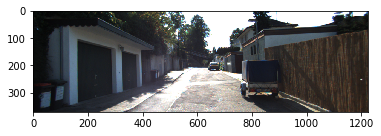

In [188]:
plt.imshow(camera_image[0])

(512, 448)
216.40150361193986 88.45359434703852 4.36 1.58 -79.381448



<Figure size 432x288 with 0 Axes>

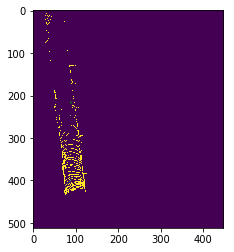

In [182]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[0, :, :, 15:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)
label = label[0]

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
#     plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


(512, 448)
216.40150361193986 88.45359434703852 31.168935183998467 8.92460187035191 -79.381448



<Figure size 432x288 with 0 Axes>

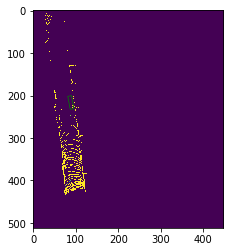

In [189]:

#groundtruth
# Create figure and axes
plt.clf()
fig,ax = plt.subplots(1)

# Display the image
img = np.clip(np.mean(lidar_image[0, :, :, 15:], 2), 0, 1)
# img = np.fliplr(img)
ax.imshow(img)
label = label[0]

print(img.shape)
for i in range(0, len(label)):
    w = label[i][3] 
    h = label[i][4] 
    x = label[i][0]
    y = label[i][1]
#     x = img.shape[0] - label[i][0]
#     y = img.shape[1] - label[i][1]
    c = 'g'
    if directions[i] >= 1.:
        c = 'b'
#     plt.scatter(y, x, s=10, c=c)
    polygon = convert5Pointto8Point(y, x, w, h, -label[i][6]*57.2958)
    xs = polygon[0::2]
    ys = polygon[1::2]
    l = []
    for j in range(4):
        l.append([xs[j], ys[j]])
    rect = patches.Polygon(l,linewidth=0.75,edgecolor='g',facecolor='none')
    ax.add_patch(rect)
    print(x, y, w, h, -label[i][6]*57.2958)

print()


plt.show()


In [196]:
t = base_path + '/data_object_label_2/training/label_2/' +current_file+".txt"
!cat $t

Misc 0.00 0 -1.82 804.79 167.34 995.43 327.94 1.63 1.48 2.37 3.23 1.59 8.55 -1.47
Car 0.00 0 -1.67 657.39 190.13 700.07 223.39 1.41 1.58 4.36 3.18 2.27 34.38 -1.58
